In [1]:
%load_ext autoreload
%autoreload 2

import os

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["WANDB_NOTEBOOK_NAME"] = "vae.ipynb"

from ml_collections import config_dict
import jax.random as random
jnp.log(jnp.exp(1) - 1.0)
# TODO: figure out why we get CUDA failures this ^ isn't here. 

from absl import logging

from src.utils.training import setup_model, get_dataset_splits, train_loop

# set save plot face color to be white
import matplotlib.pyplot as plt
plt.rcParams["savefig.facecolor"] = "white"

In [2]:
RUN_EXTRA = False

In [3]:
logging.set_verbosity(logging.INFO)

In [4]:
rng = random.PRNGKey(0)
data_rng, model_rng = random.split(rng)

In [5]:
def get_config(params) -> config_dict.ConfigDict:
    config = config_dict.ConfigDict()

    angle, num_trn, total_steps = params.split(",")[:3]
    config.angle = int(angle)
    config.num_trn = int(num_trn)
    config.num_val = 10000
    config.total_steps = int(total_steps)

    config.seed = 0
    # Dataset config
    config.dataset = "MNIST"
    # config.data_dir = '~/data'
    config.shuffle_buffer_size = 50_000
    config.repeat_after_batch = True  # NOTE: ordering of PP and repeat is important!
    config.train_split = f"train[{config.num_val}:{config.num_val+config.num_trn}]"
    config.pp_train = (
        f'value_range(-1, 1)|random_rotate(-{config.angle}, {config.angle}, fill_value=-1)|keep(["image"])'
    )
    config.val_split = f"train[:{config.num_val}]"
    config.pp_eval = f'value_range(-1, 1)|random_rotate(-{config.angle}, {config.angle}, fill_value=-1)|keep(["image", "label"])'

    # Model config
    config.model_name = "VAE"
    config.model = config_dict.ConfigDict()
    config.model.latent_dim = 16
    ## q(Z|X) config
    config.model.Z_given_X = config_dict.ConfigDict()
    config.model.Z_given_X.conv_dims = [64, 128, 256]
    config.model.Z_given_X.dense_dims = [256]
    config.model.Z_given_X.max_2strides = 2
    ## p(X|Z) config
    config.model.X_given_Z = config_dict.ConfigDict()
    config.model.X_given_Z.conv_dims = [256, 128, 64]
    config.model.X_given_Z.dense_dims = [256]
    config.model.X_given_Z.max_2strides = 2

    # Training config
    config.eval_every = 500
    config.batch_size = 512
    config.batch_size_eval = 256

    ## Optimizer config
    config.optim_name = "adamw"
    config.learning_rate = 1e-4
    config.optim = config_dict.ConfigDict()
    config.optim.weight_decay = 1e-4

    ## LR config
    config.lr_schedule_name = "warmup_cosine_decay_schedule"
    config.lr_schedule = config_dict.ConfigDict()
    config.lr_schedule.peak_value = 10 * config.learning_rate
    config.lr_schedule.end_value = 1 * config.learning_rate
    config.lr_schedule.decay_steps = config.total_steps
    config.lr_schedule.warmup_steps = config.total_steps // 10

    ## α config
    config.α = 1

    ## β config
    config.β = 10
    config.β_schedule_name = "cosine_decay_schedule"
    config.β_schedule = config_dict.ConfigDict()
    β_end_value = 1
    config.β_schedule.alpha = β_end_value / config.β
    config.β_schedule.decay_steps = config.total_steps

    ## γ config
    config.γ = 1

    # MLL config
    config.run_hais = True
    config.hais = config_dict.ConfigDict()
    config.hais.num_chains = 300
    config.hais.num_steps = 100
    config.hais.step_size = 8e-3
    config.hais.num_leapfrog_steps = 2
    config.run_iwlb = True
    config.iwlb = config_dict.ConfigDict()
    config.iwlb.num_samples = 100

    return config

config = get_config('0,50000')

In [6]:
train_ds, val_ds, _ = get_dataset_splits(config, data_rng, config.batch_size, config.get('batch_size_eval', config.batch_size))

INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


INFO:absl:Features after op ValueRange(vmin=-1, vmax=1, in_min=0, in_max=255.0, clip_values=False, key='image', key_result=None):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op RandomRotate(θ_min=0.0, θ_max=0.0, fill_mode='nearest', fill_value=-1, key='image', key_result=None, rng_key='rng'):
{'image': 'float32[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:Features after op Keep(keys=['image']):
{'image': 'float32[28, 28, 1]'}
INFO:absl:Features after preprocessing: {'image': 'float32[28, 28, 1]'}
INFO:absl:Initializing val dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.mo

In [7]:
model, state = setup_model(config, model_rng, train_ds)

INFO:absl:Initializing model...
INFO:absl:config.model_name = VAE
INFO:absl:config.model = X_given_Z:
  conv_dims:
  - 256
  - 128
  - 64
  dense_dims:
  - 256
  max_2strides: 2
Z_given_X:
  conv_dims:
  - 64
  - 128
  - 256
  dense_dims:
  - 256
  max_2strides: 2
latent_dim: 16

INFO:absl:input_size = (28, 28, 1)
INFO:absl:Initializing model...
INFO:absl:
+-----------------------------------+------------------+---------+-----------+----------+
| Name                              | Shape            | Size    | Mean      | Std      |
+-----------------------------------+------------------+---------+-----------+----------+
| params/p_X_given_Z/conv_1/bias    | (256,)           | 256     | 0.0       | 0.0      |
| params/p_X_given_Z/conv_1/kernel  | (3, 3, 3, 256)   | 6,912   | 0.000388  | 0.193    |
| params/p_X_given_Z/conv_2/bias    | (128,)           | 128     | 0.0       | 0.0      |
| params/p_X_given_Z/conv_2/kernel  | (3, 3, 256, 128) | 294,912 | 1.1e-05   | 0.0208   |
| params/p_

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


INFO:absl:Setting up datasets...
INFO:absl:Global batch size 512 on 1 hosts results in 512 local batch size. With 1 devices per host (1 devices total), that's a 512 per-device batch size.
INFO:absl:Initializing train dataset...
INFO:absl:Load dataset info from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Field info.citation from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.splits from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.supervised_keys from disk and from code do not match. Keeping the one from code.
INFO:absl:Field info.module_name from disk and from code do not match. Keeping the one from code.
INFO:absl:Constructing tf.data.Dataset mnist for split _EvenSplit(split='train[10000:60000]', index=0, count=1, drop_remainder=False), from /homes/jua23/tensorflow_datasets/mnist/3.0.1
INFO:absl:Features before preprocessing: {'image': 'uint8[28, 28, 1]', 'label': 'int64[]', 'rng': 'int32[2]'}
INFO:absl:F

  0%|          | 0/7501 [00:00<?, ?it/s]

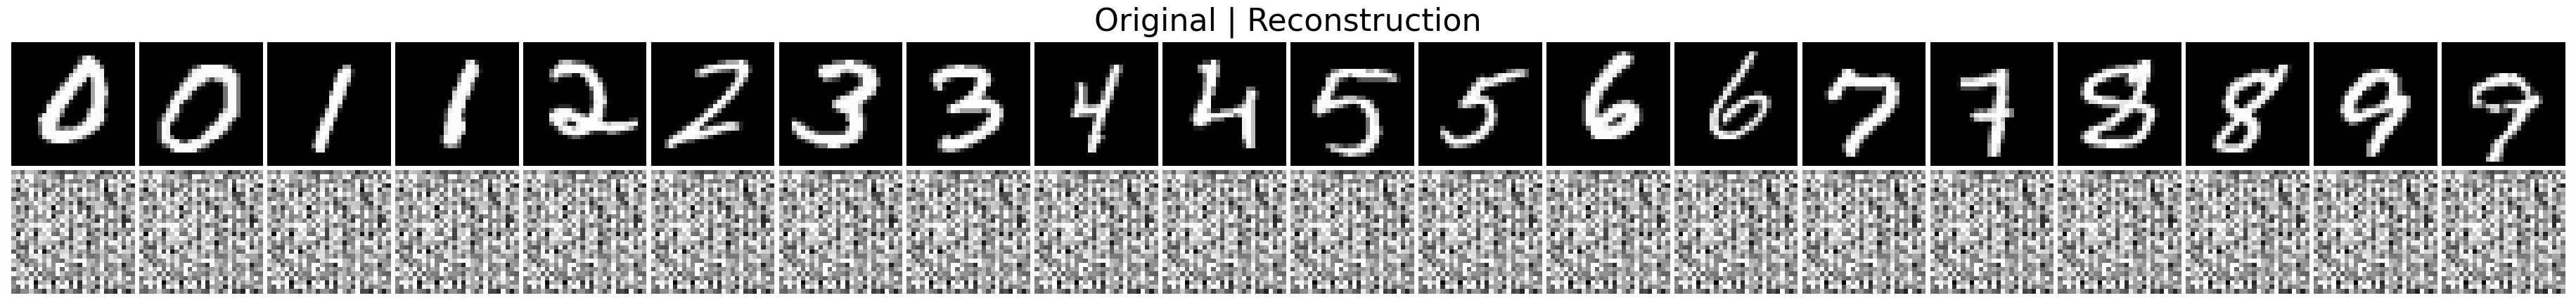

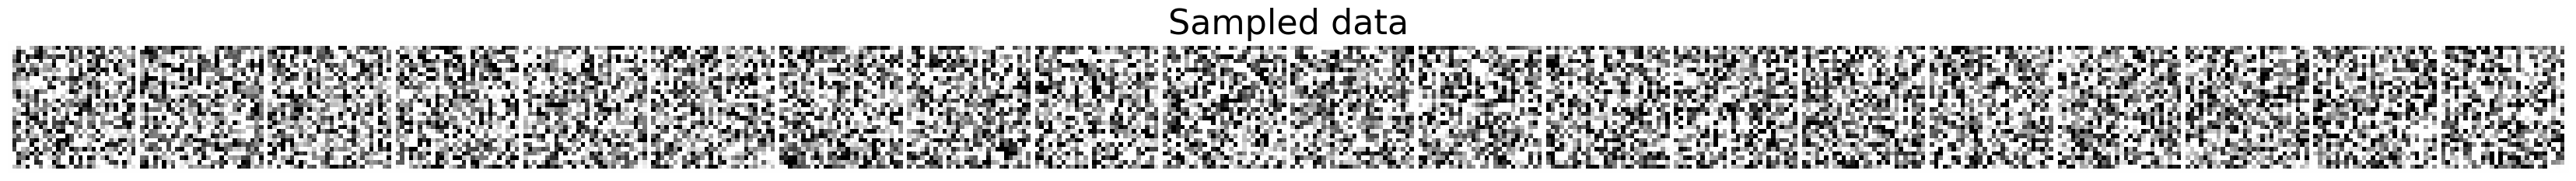

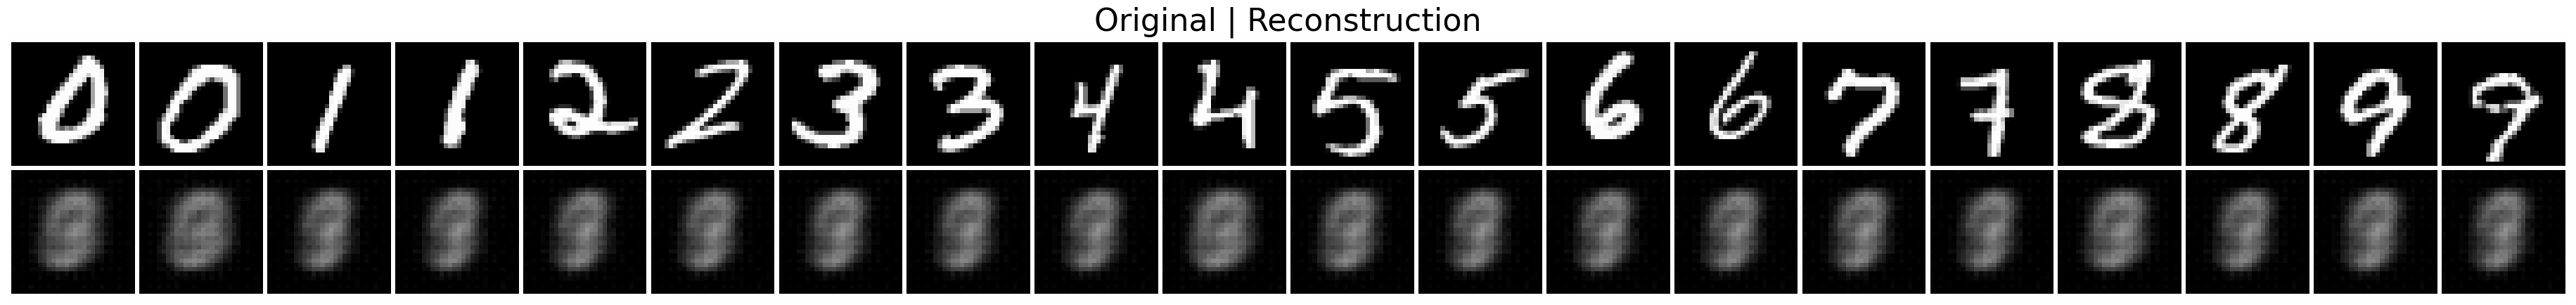

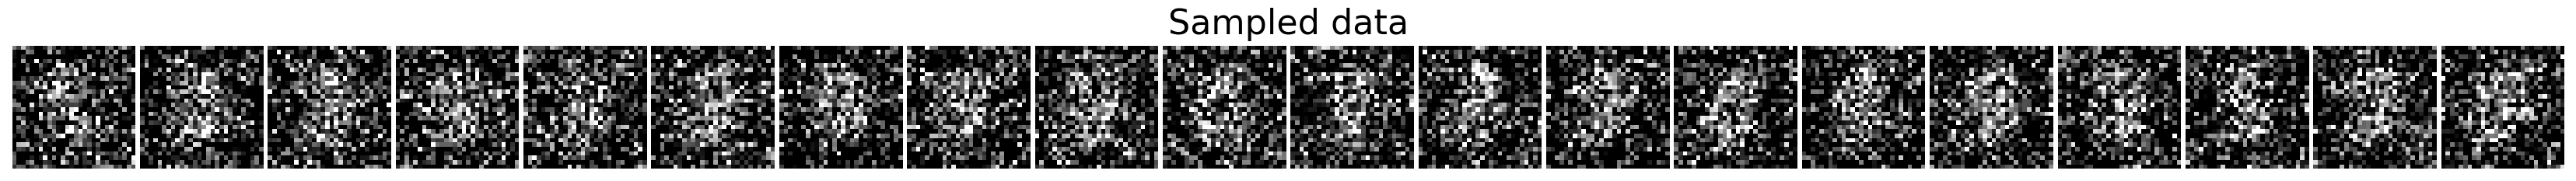

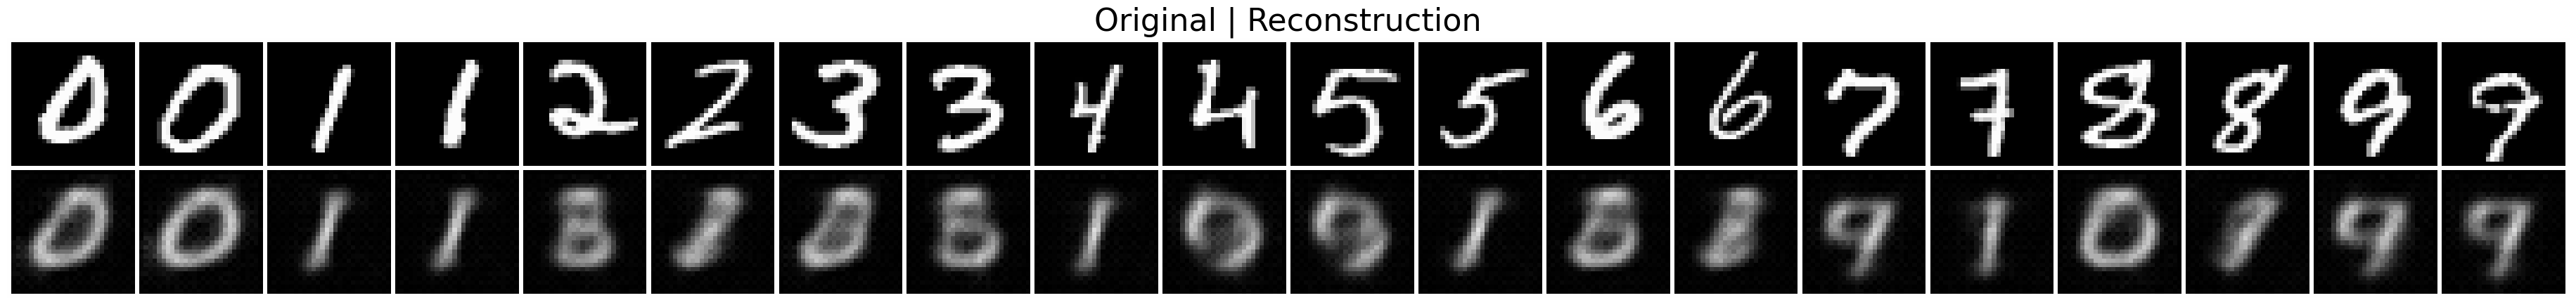

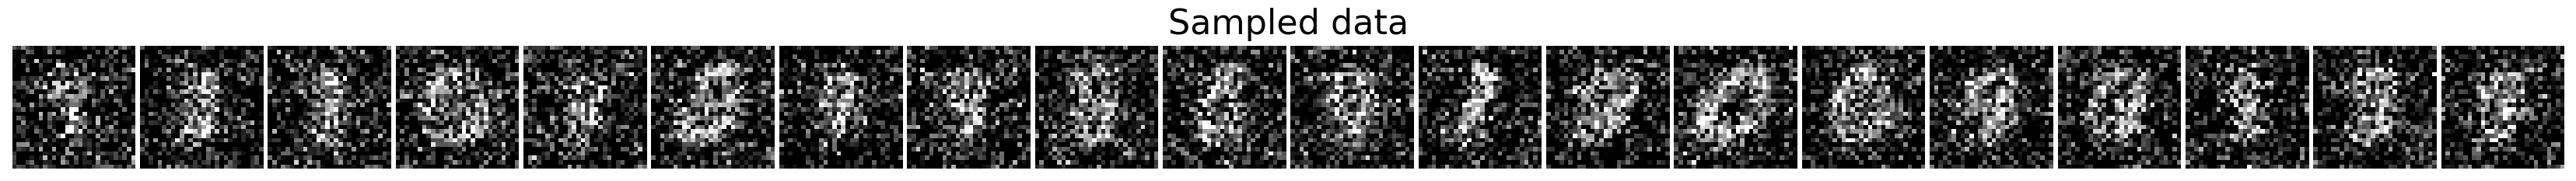

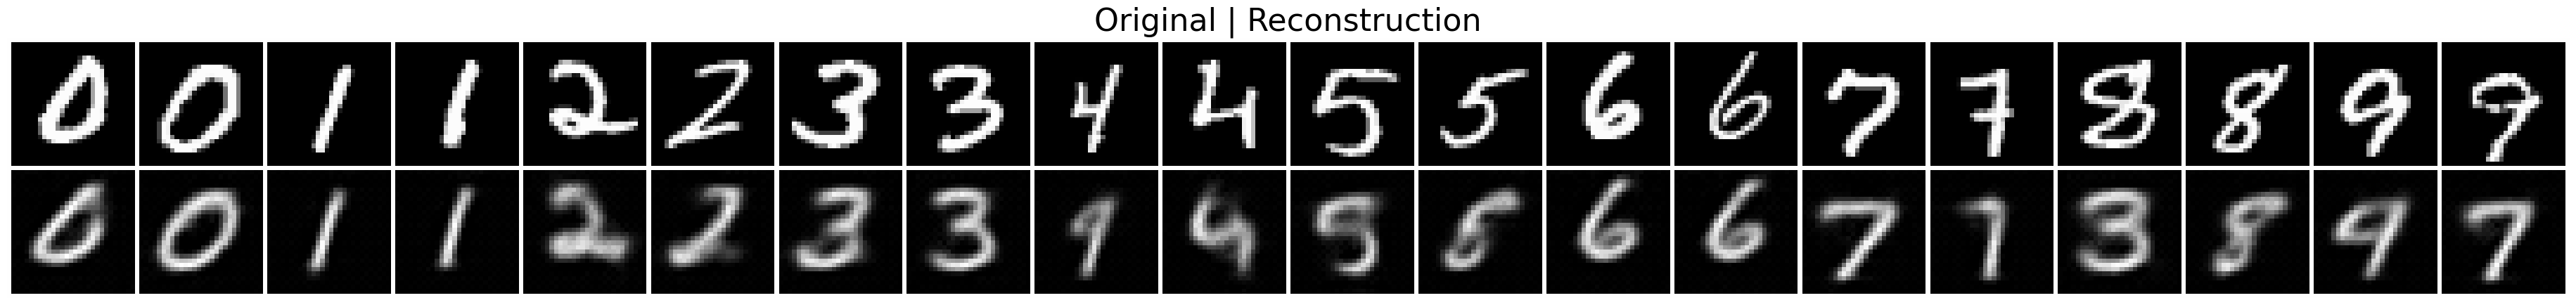

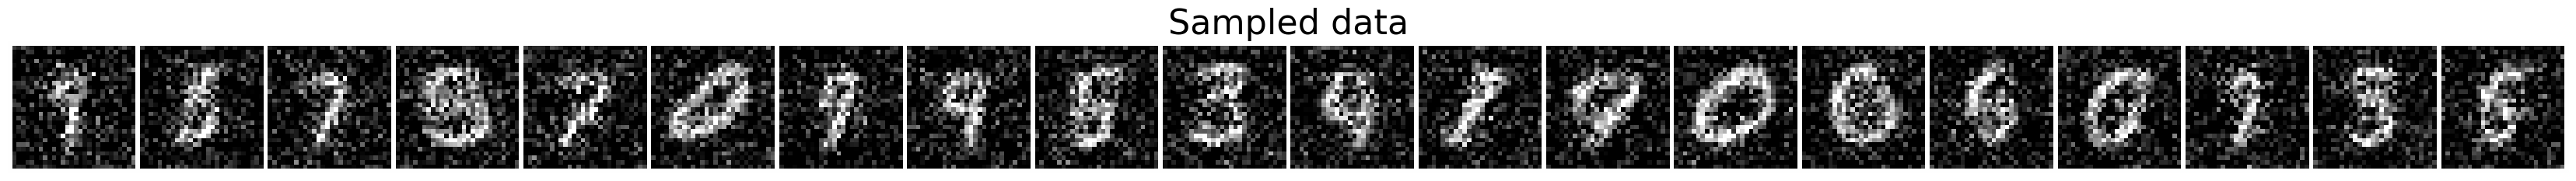

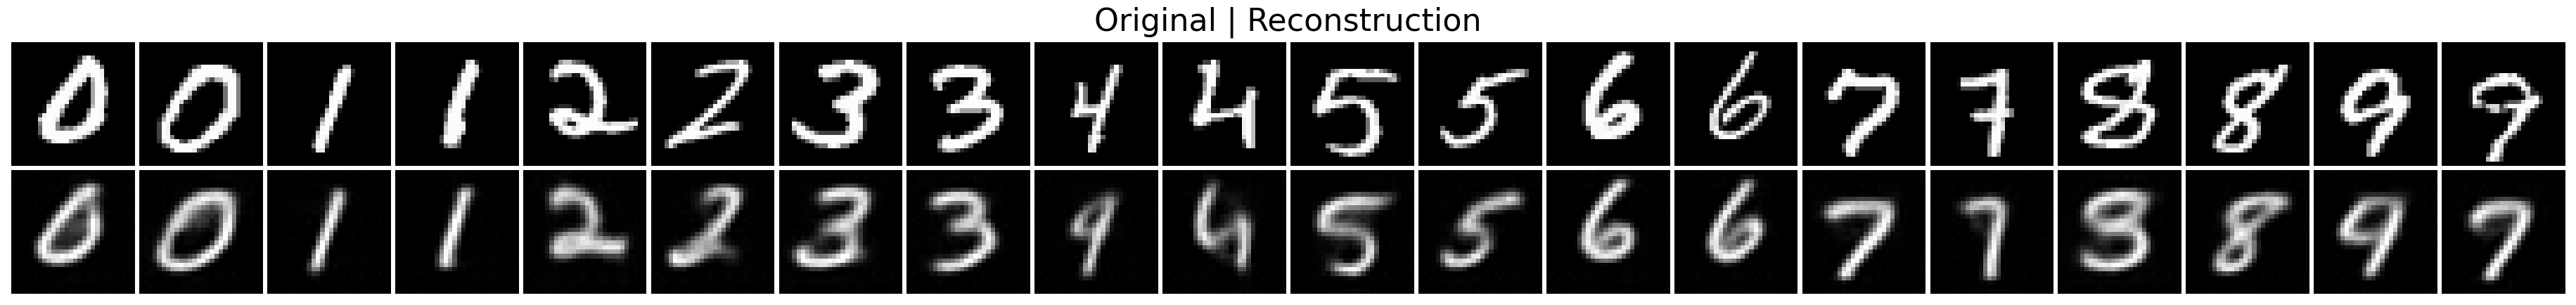

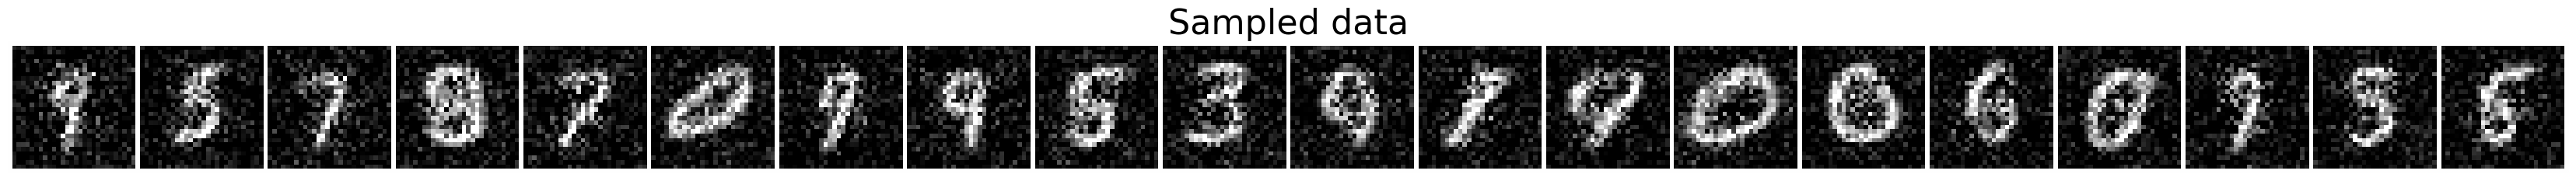

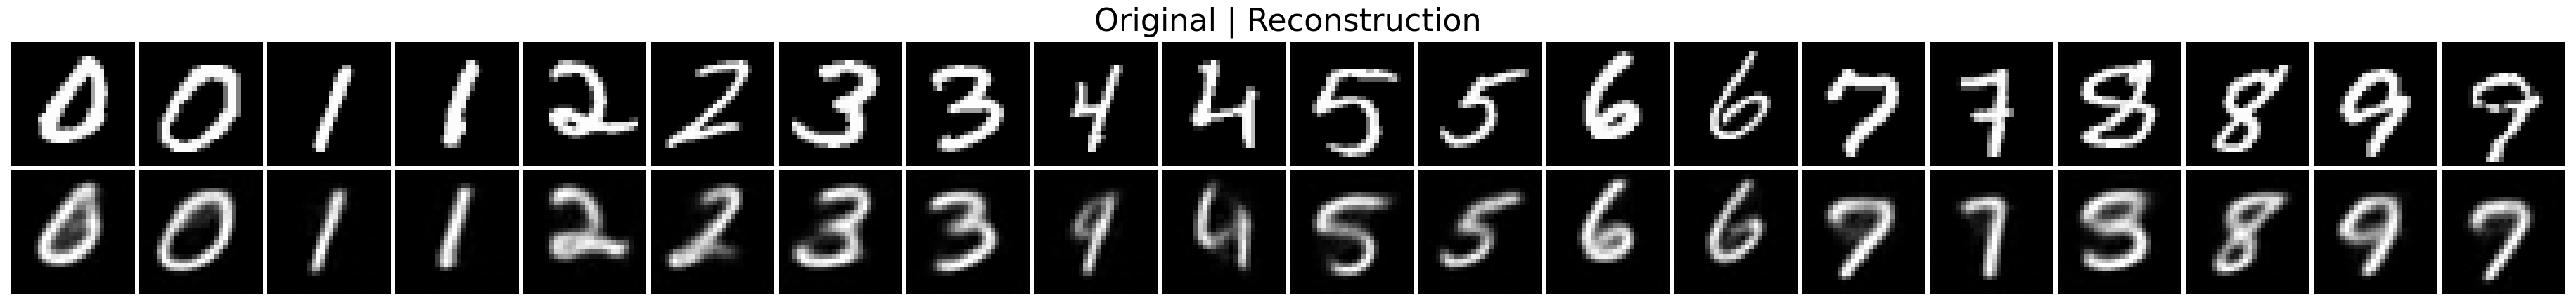

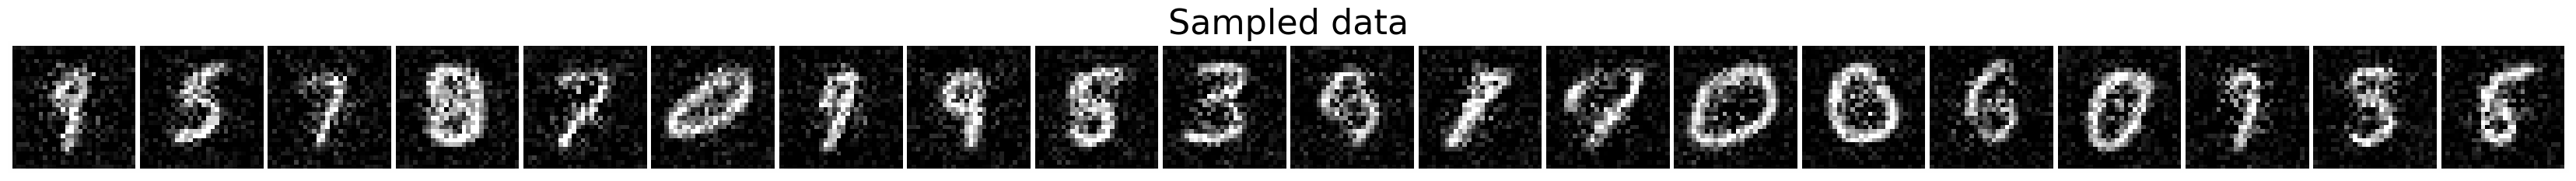

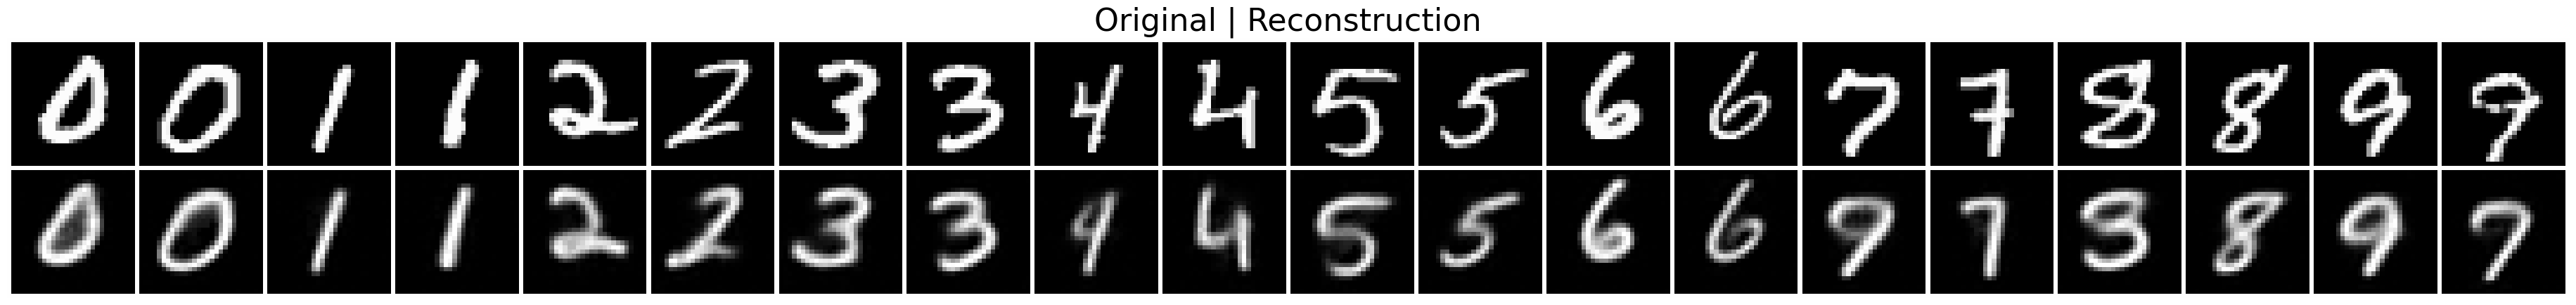

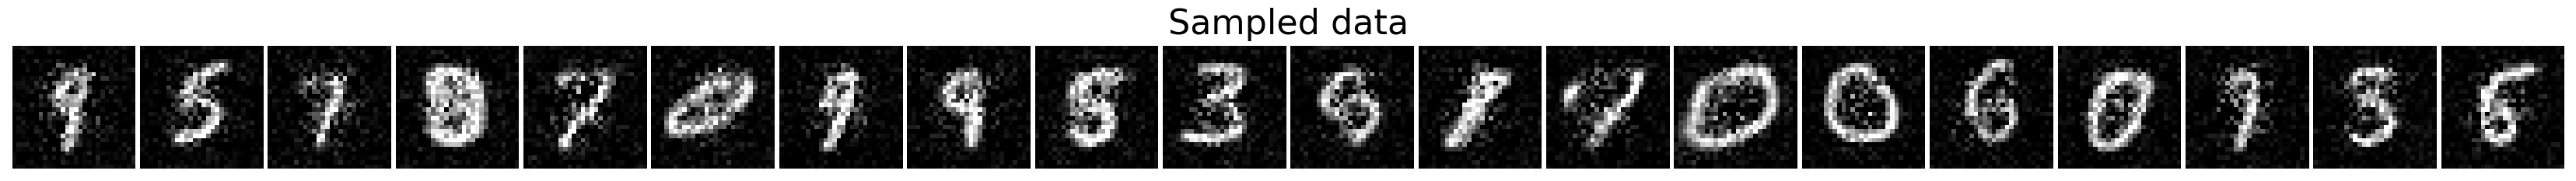

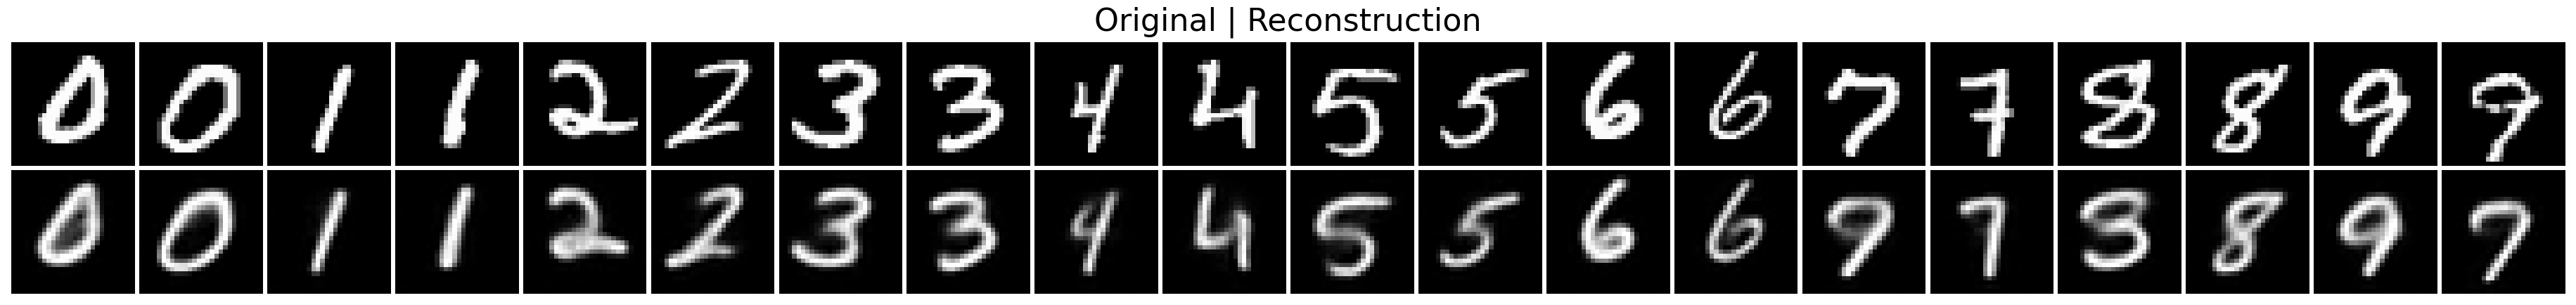

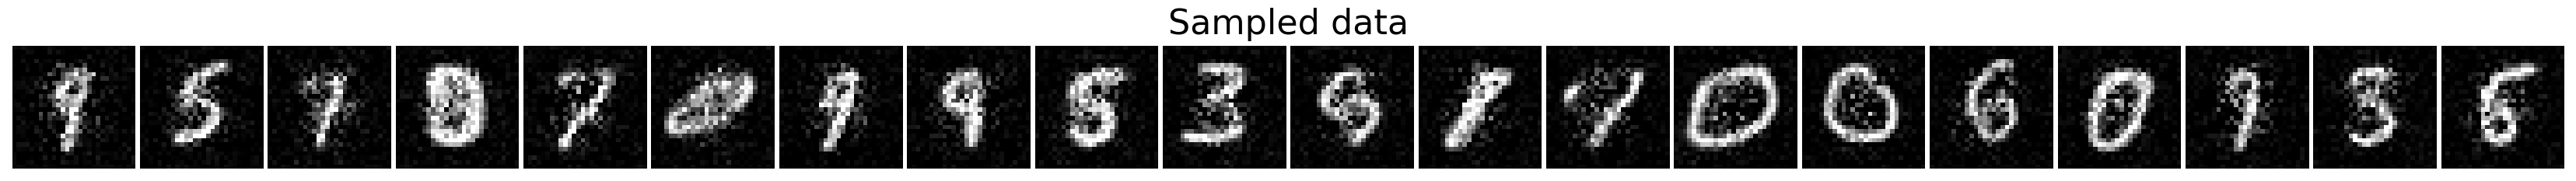

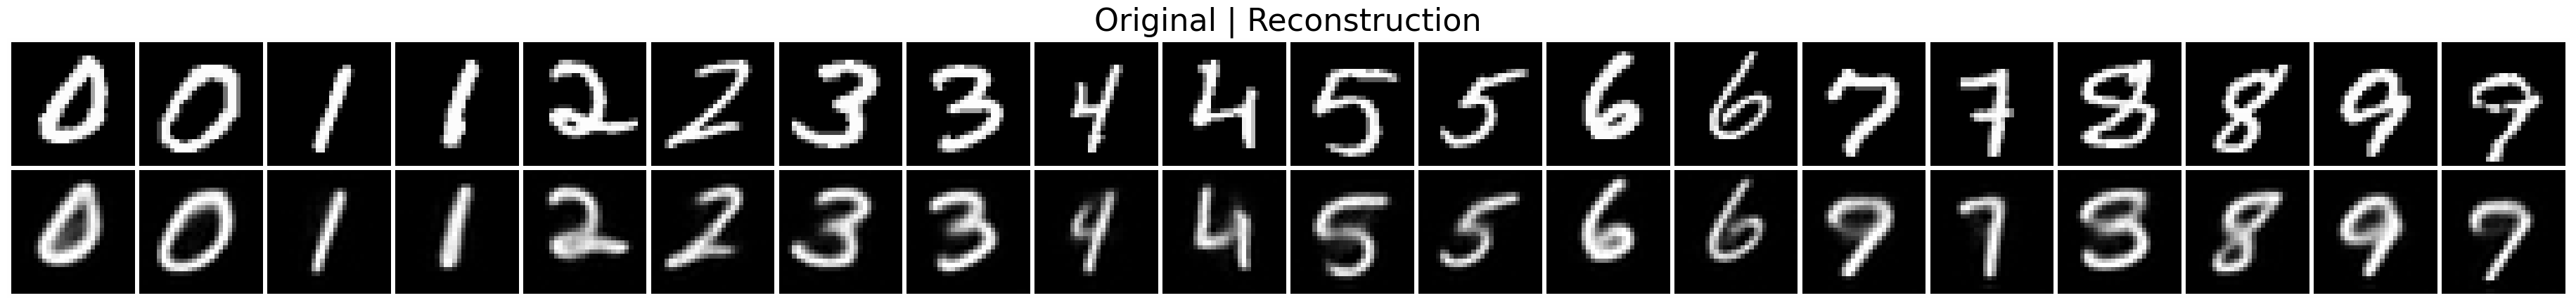

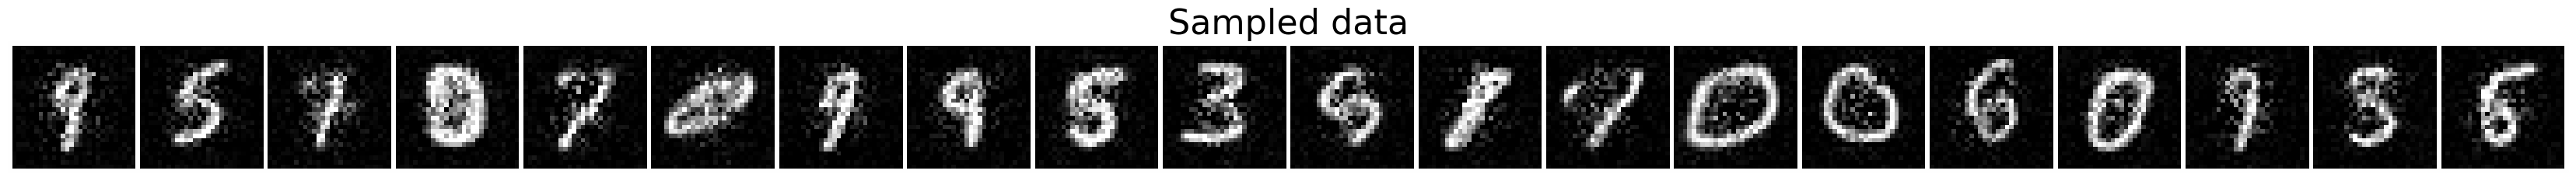

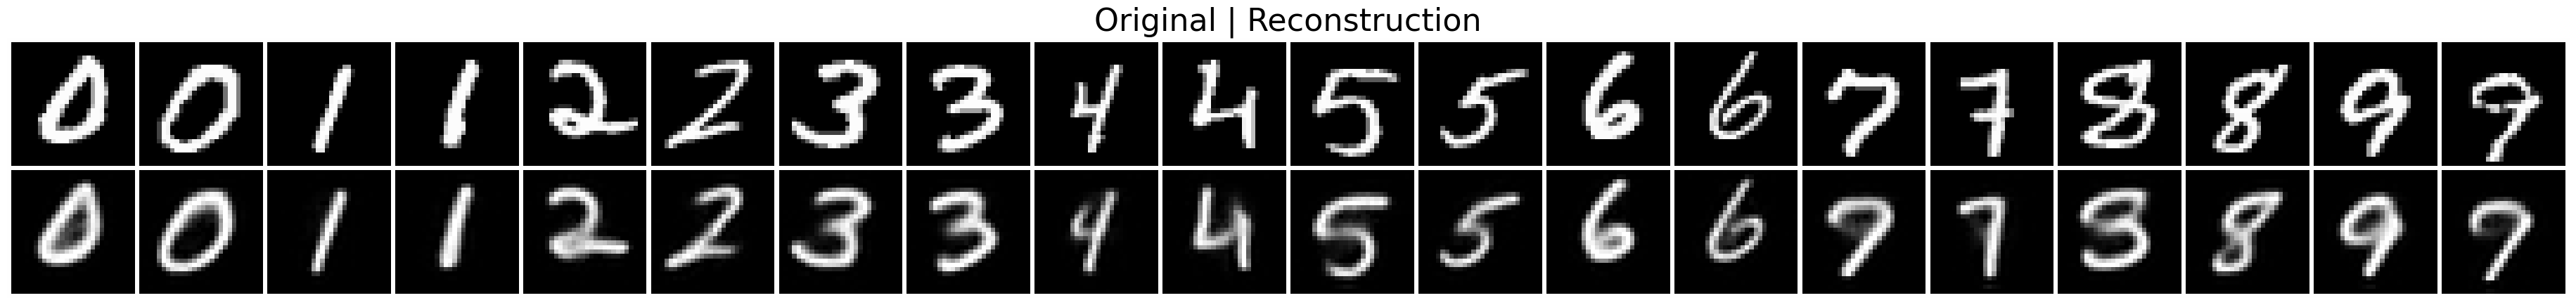

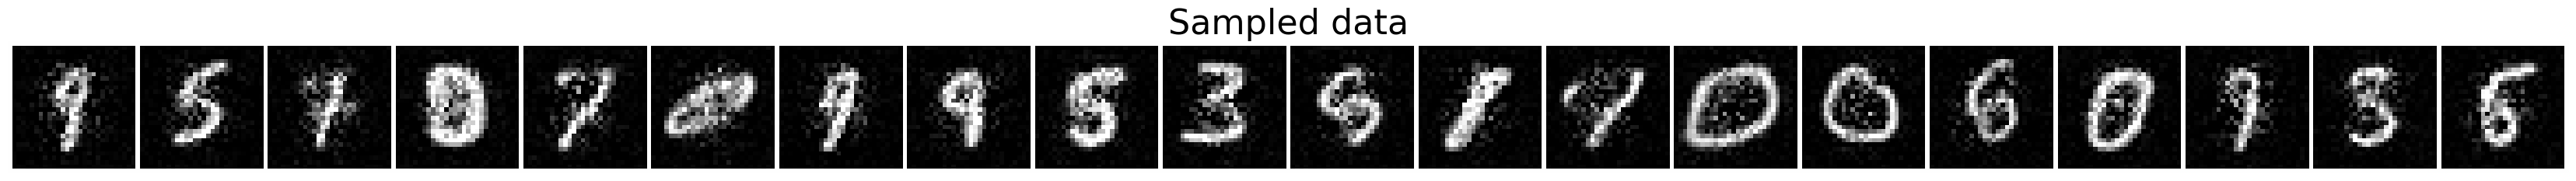

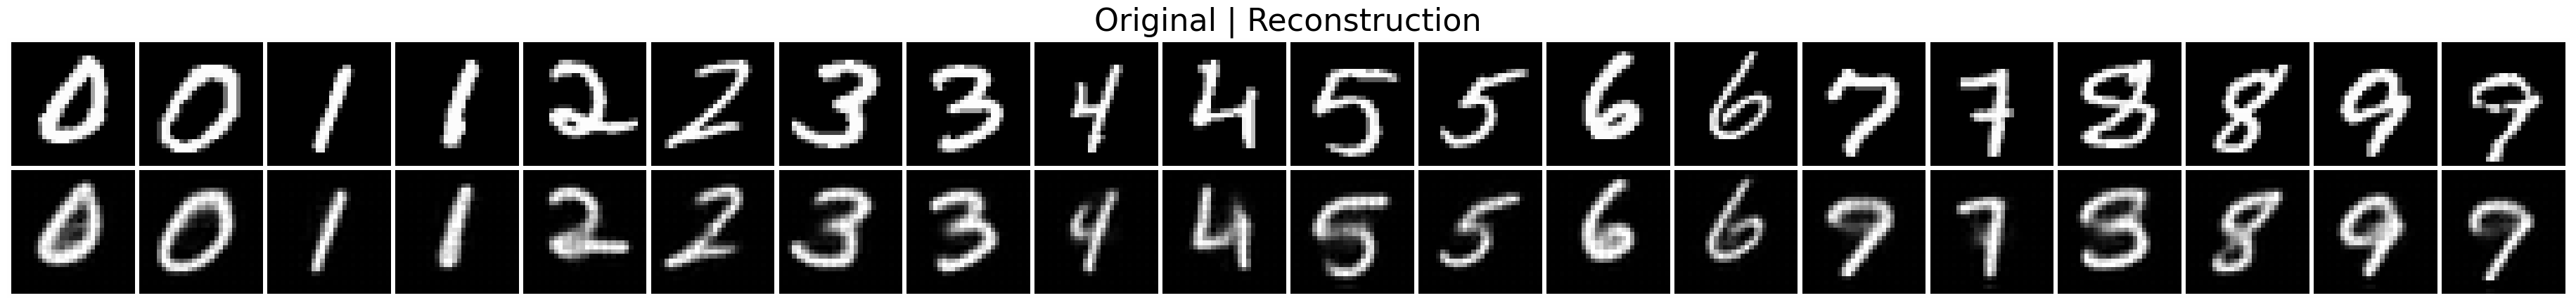

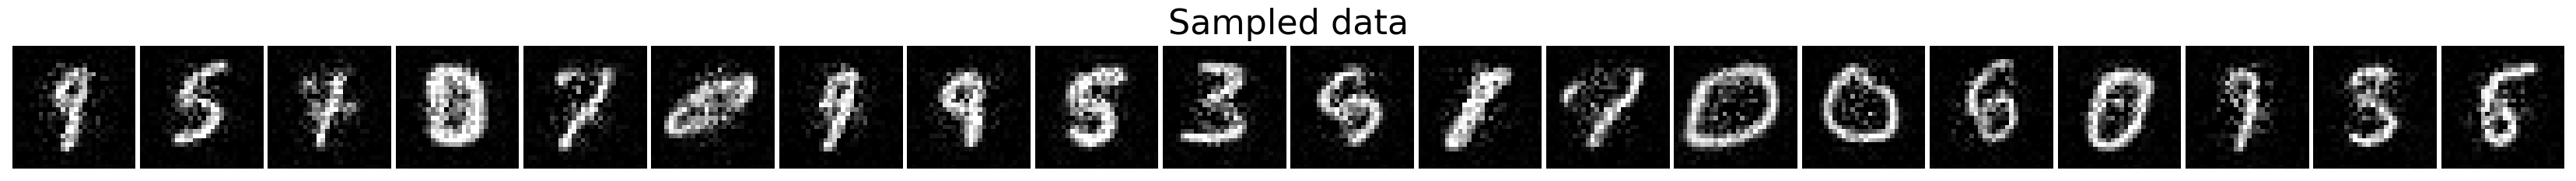

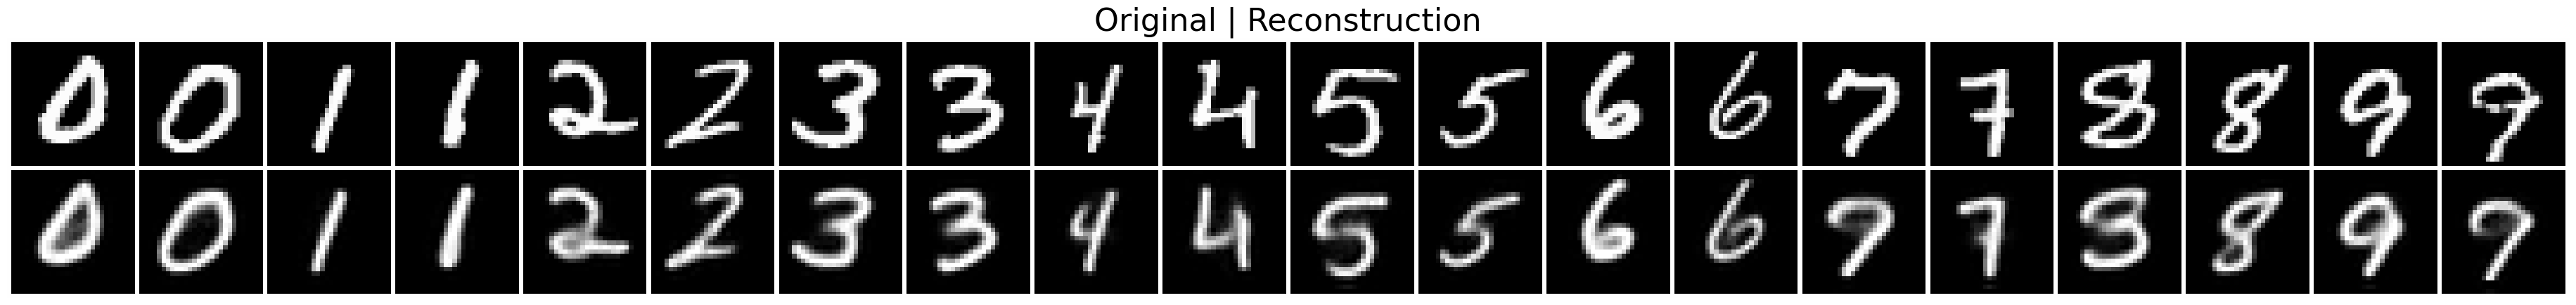

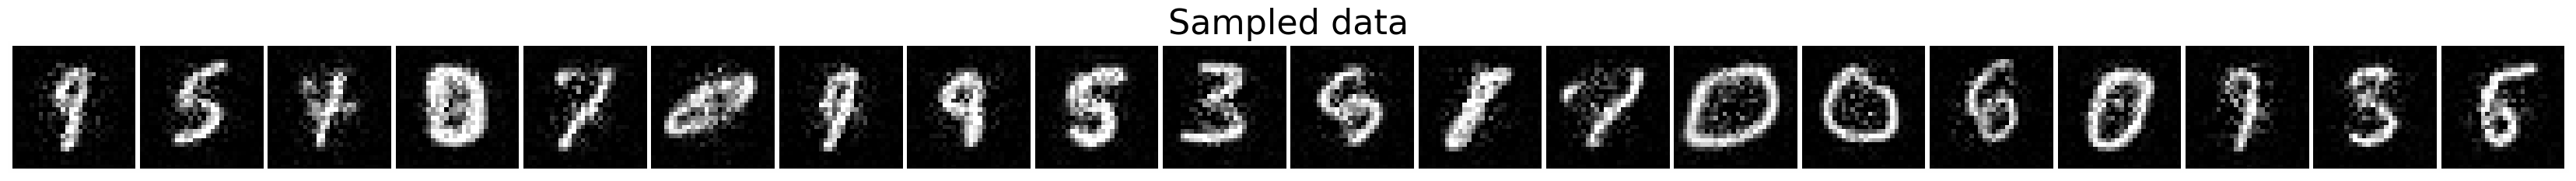

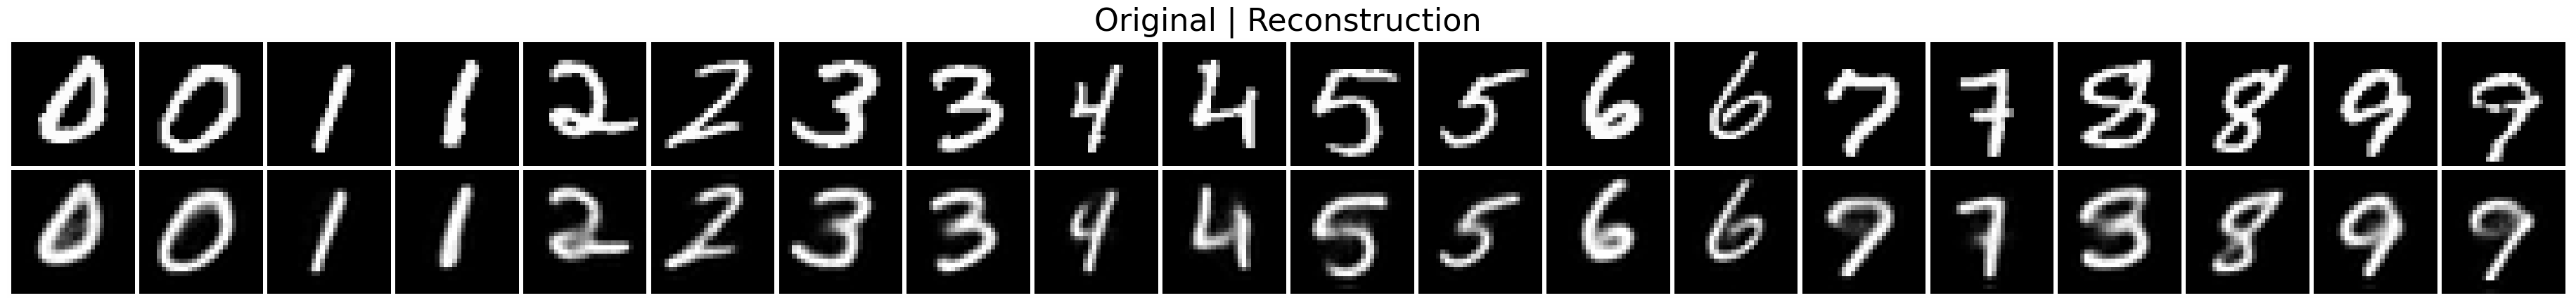

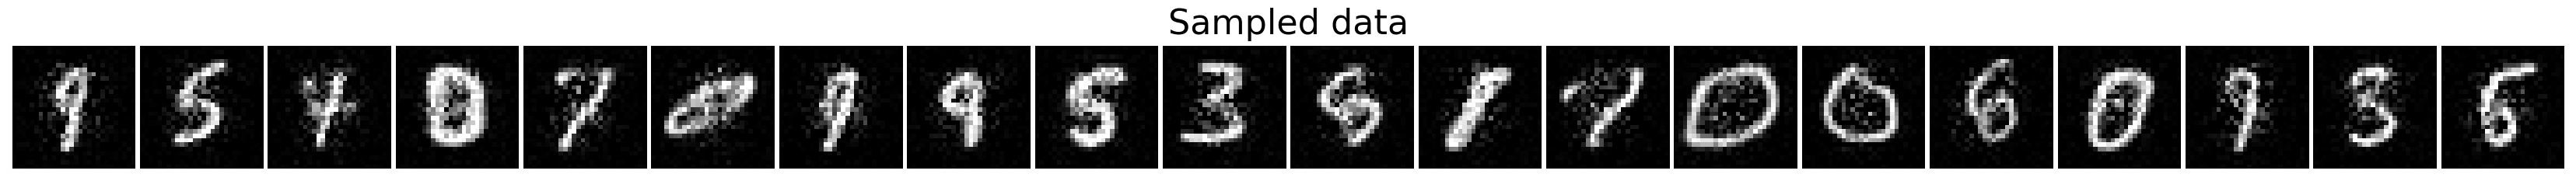

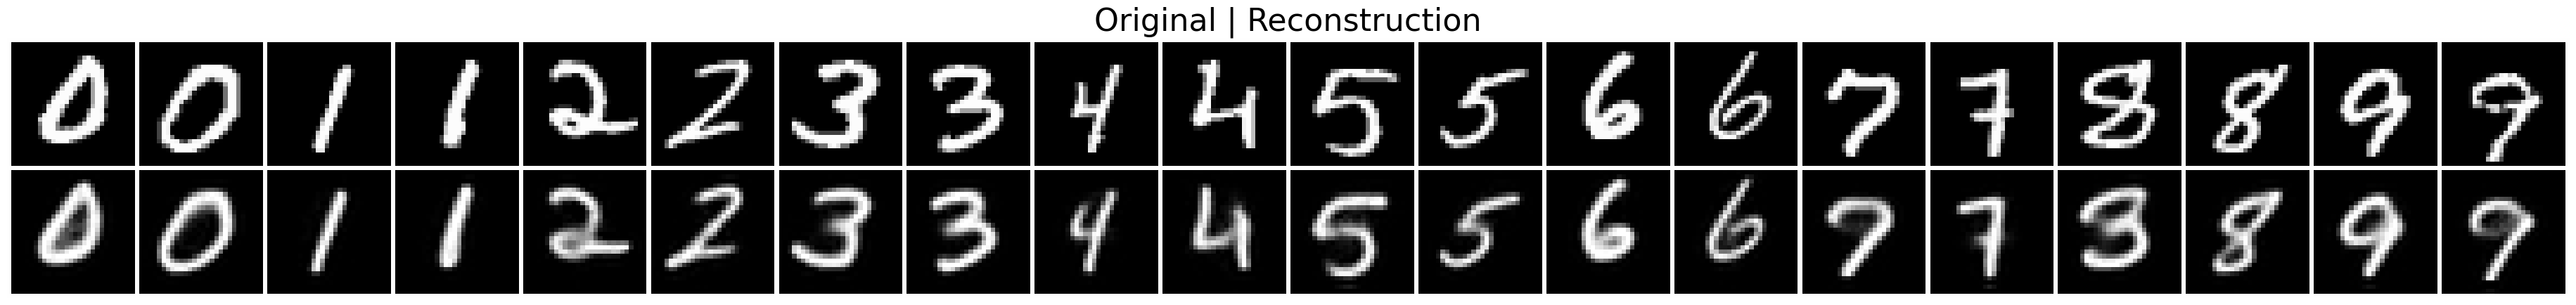

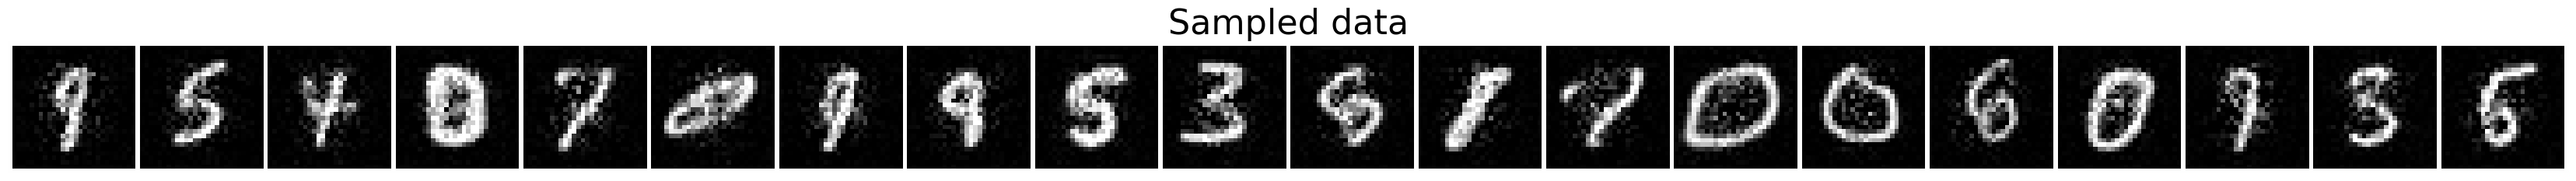

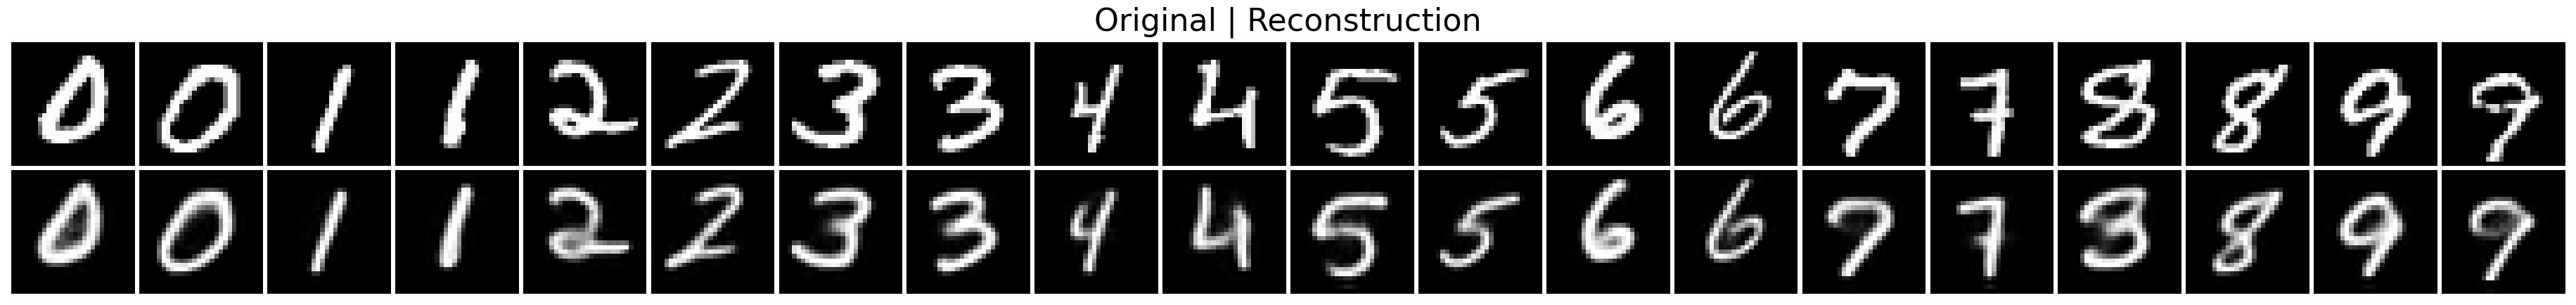

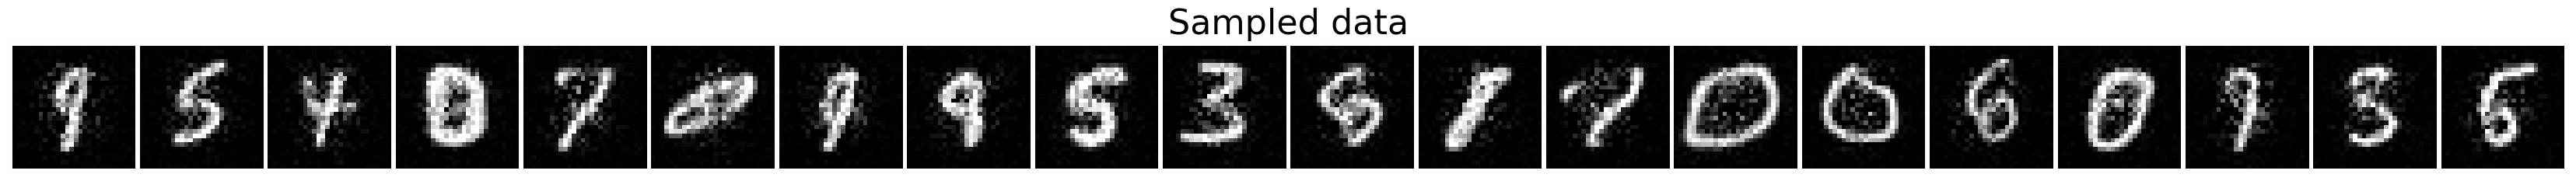

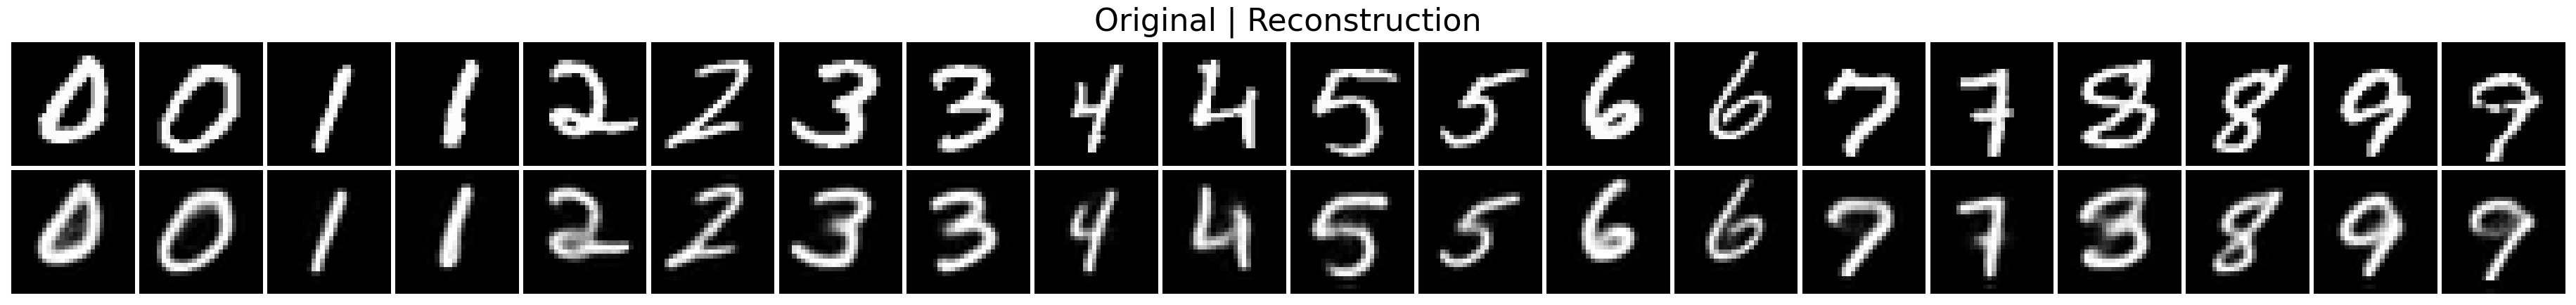

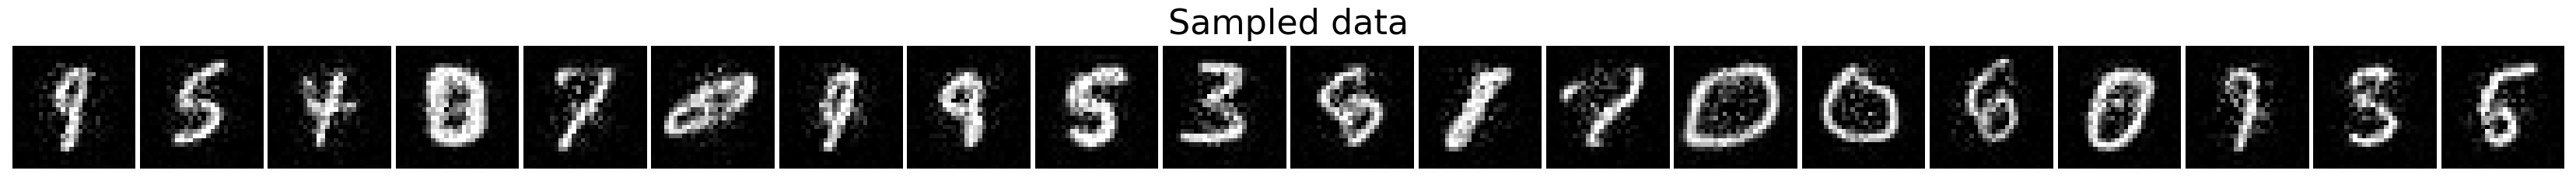

INFO:absl:Training finished.


0it [00:00, ?it/s]

2023-06-17 00:02:48.049121: W external/org_tensorflow/tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 14.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


learing_rate,▂▃▅▆██████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/elbo,▁▁▁▁▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████████
train/ll,▁▁▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇██████████
train/loss,████▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/z_kld,▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
val/elbo,▁▃▃▄▅▅▆▆▇▇▇▇████
val/iwlb,▁▃▃▄▅▆▆▆▇▇▇█████
val/ll,▁▃▃▄▅▅▆▆▇▇▇█████
val/loss,█▆▆▅▄▄▃▃▂▂▂▂▁▁▁▁
val/z_kld,▁▁▁▂▃▃▄▄▄▅▆▆▇▇██
α,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


RuntimeError: UNKNOWN: Failed to determine best cudnn convolution algorithm for:
%cudnn-conv = (f32[76800,28,28,64]{2,1,3,0}, u8[0]{0}) custom-call(f32[76800,28,28,1]{2,1,3,0} %bitcast, f32[3,3,64,1]{1,0,3,2} %copy.1), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_01oi->b01f, custom_call_target="__cudnn$convForward", metadata={op_name="jit(conv_general_dilated)/jit(main)/conv_general_dilated[window_strides=(1, 1) padding=((1, 1), (1, 1)) lhs_dilation=(1, 1) rhs_dilation=(1, 1) dimension_numbers=ConvDimensionNumbers(lhs_spec=(0, 3, 1, 2), rhs_spec=(2, 3, 0, 1), out_spec=(0, 3, 1, 2)) feature_group_count=1 batch_group_count=1 lhs_shape=(76800, 28, 28, 1) rhs_shape=(3, 3, 64, 1) precision=None preferred_element_type=None]" source_file="/var/home/jua23/.virtualenvs/inv/lib/python3.9/site-packages/flax/linen/linear.py" source_line=389}, backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"

Original error: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 15430844416 bytes.

To ignore this failure and try to use a fallback algorithm (which may have suboptimal performance), use XLA_FLAGS=--xla_gpu_strict_conv_algorithm_picker=false.  Please also file a bug for the root cause of failing autotuning.

In [8]:
best_state, final_state = train_loop(
    config,
    model,
    state,
    train_ds,
    val_ds,
    wandb_kwargs={
        'mode': 'online',
        'tags': ['test', 'vae', 'mnist'], 
        'notes': (
            'Comparing VAE on MNIST with and without affine transformations applied to the data. '
            'This is to see if the affine transformations in SSILVAE are a problem. '
            'This run has the affine transformations. '
            'Also adding affine to iwlb calc. '
        )
    }
);


In [9]:
if RUN_EXTRA:
    pass
else:
    raise RuntimeError("Set RUN_EXTRA to True to keep running NB.")

RuntimeError: Set RUN_EXTRA to True to keep running NB.

In [ ]:
import src.utils.input as input_utils
import src.utils.plotting as plotting_utils
from src.transformations import transform_image

In [ ]:
ds = input_utils.start_input_pipeline(val_ds, 1)
xs_ = next(ds)['image'][0]
xs = xs_[:50]

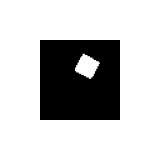

In [ ]:
x = xs[0]
fig = plt.figure(figsize=(.5, .5), dpi=400)
plt.imshow(x, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from src.models.vae import create_vae_hais_mll_estimator
import jax
estimate_mll = create_vae_hais_mll_estimator(
    model, best_state.params, train=False, num_chains=10, num_steps=300, step_size=1e-2, num_leapfrog_steps=2
)

In [ ]:
bs = 256
n_iters = 256 // bs
mlls = []
for i in range(n_iters):
    mlls.append(jax.vmap(estimate_mll, in_axes=(0, None))(xs_[i*bs:(i+1)*bs], rng).mean(axis=0))

mlls = jnp.array(mlls)
mll = mlls.mean(axis=0)
mll

DeviceArray(-4979.3594, dtype=float32)

In [ ]:
# 300 -> 4044, 4m 47.0s ... 3m 19.5s
# 100 -> 4717, 2m 52s  ... 1m 34s

In [ ]:
# Step size | Num chains | Num steps | Num Leap Frogs | MLL    | Time
# 1e-2      | 100        |    1      | 2              | 123531 | 22.8s (bs = 10)
# 1e-2      | 100        |    3      | 2              |  47443 | 16.8s (bs = 10)
# 1e-2      | 100        |   10      | 2              |  15982 | 23.2s (bs = 10)
# 1e-2      | 100        |   30      | 2              |   7777 | 31.8s (bs = 10)
# 1e-2      | 100        |  100      | 2              |   4956 | 1m 6.8s (bs = 10)
# 1e-2      | 100        |  300      | 2              |   4139 | 2m 58.0s (bs = 10)

# 1e-2      | 300        |   30      | 2              |   9236 | 1m 30.6s (bs = 10)
# 1e-2      | 100        |   30      | 2              |   7777 | 31.8s (bs = 10)
# 1e-2      |  30        |   30      | 2              |   6941 | 36.2  (bs = 10)
# 1e-2      |  10        |   30      | 2              |   6941 | 29.0s (bs = 10)

# 1e-4      | 100        |   30      | 2              | 123125 | 28.8s (bs = 10)
# 1e-3      | 100        |   30      | 2              |  91249 | 30.8s (bs = 10)
# 1e-2      | 100        |   30      | 2              |   7777 | 31.8s (bs = 10)
# 1e-1      | 100        |   30      | 2              | 123531 | 30.6s (bs = 10)
# 1e-0      | 100        |   30      | 2              | 123531 | 32.0s (bs = 10)

# 1e-2      | 100        |   30      | 1              |  10307 | 22.0s (bs = 10)
# 1e-2      | 100        |   30      | 2              |   7777 | 31.8s (bs = 10)
# 1e-2      | 100        |   30      | 4              |  29250 | 43.4s (bs = 10)
# 1e-2      | 100        |   30      | 8              |  16997 | 1m 7.3s (bs = 10)

# +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

# 1e-2      | 100        | 1000      | 2             |   3865  | 10m 30.5s (bs = 2)
# 1e-2      | 100        |  300      | 2             |   3315  | 4m
# 1e-2      | 100        |  100      | 2             |   3560  | 1m 53.0s (bs = 2)
# 3e-2      | 100        |  300      | 2             |  24067  | 2m 55 (bs = 10)
# 7e-3      | 100        |  300      | 2             |   3331  | 2m 55 (bs = 10)
# 3e-3      | 100        |  300      | 2             |   3857  | 2m 55 (bs = 10)
# 1e-2      | 10         |  300      | 2             |   3287  | 44s (bs = 10)
# 1e-2      | 30         |  300      | 2             |   3305  | 1m 20s (bs = 10)
# 1e-2      | 10         |  1000     | 2             |   3237  | 1m 14 (bs = 10)
# 1e-2      | 10         |  3000     | 2             |   3229  | 3m 11 (bs = 10)
# 1e-2      | 30         |  1000     | 2             |   3241  | 3m 39 (bs = 10)
# 1e-2      | 30         |  3000     | 2             |   3231  | 8m 32 (bs = 10)


# Step size | Num chains | Num steps | Num Leap Frogs | MLL        | Time
# 1e-1      | 100        | 1000      | 2              | 652.18     | 17.1s
# 1e-2      | 100        | 1000      | 2              | 477.62     |
# 2e-1      | 100        | 1000      | 2              | 633.18     |
# 5e-1      | 100        | 1000      | 2              | 572.47     |
# 1e-1      | 100        | 1000      | 8              | 657.97     | 53.4s
# 1e-1      | 100        | 1000      | 16             | 656.50     | 1m 42.5s
# 1e-1      | 300        | 1000      | 2              | 652.18     | 1m 1.3s
# 1e-1      | 100        | 3000      | 2              | 657.91     | 47.9s
# 1e-1      | 100        |  200      | 2              | 630.28     | 6.3s
# 1e-1      | 100        |  300      | 2              | 636.63     | 7.9s
# 1e-1      | 100        |  500      | 2              | 644.46     | 9.6s

In [ ]:
@jax.vmap
@jax.jit
def importance_weighted_lower_bound(x):
    return model.apply({'params': best_state.params}, x, rng, num_samples=100, method=model.importance_weighted_lower_bound)

In [ ]:
from tqdm.auto import tqdm

In [ ]:
iwlbs = []
num_examples = 0
for batch in tqdm(input_utils.start_input_pipeline(val_ds, 1)):
    iwlbs.append(importance_weighted_lower_bound(batch['image'][0]))
    num_examples += batch['mask'][0].sum()


iwlb = jnp.concatenate(iwlbs, axis=0).sum(axis=0) / num_examples
iwlb

0it [00:00, ?it/s]

DeviceArray(-4985.4126, dtype=float32)

In [ ]:
# num_samples | IWLB | diff
#        1500 | 3708 | ---
#        1000 | 3706 | ---
#         500 | 3701 | 5
#         100 | 3691 | 10
#          50 | 3686 | 5
#          10 | 3673 | 13
#           5 | 3665 | 8
#           3 | 3656 | 9
#           2 | 3647 | 9
#           1 | 3618 | 29